# Libraries and Functions

In [141]:
!pip3 install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [142]:
# Basic Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [143]:
# Modeling and Resampling Libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [144]:
def evaluate_model(name, model, X, y, sample_weights=None):
    """
    Evaluates a classification model on a dataset.
    
    Parameters
    ------------
    name (str): Name of the model
    model (sklearn model): ML model to evaluate
    X (DataFrame): Features dataset
    y (series): Target of the dataset (True labels)
    
    Returns
    ------------
    res (dictionary): Dictionary with evaluation results
    """
    
    # Predict probabilities and class labels
    y_pred_proba = model.predict_proba(X)[:, 1]  # Probabilities for the positive class
    y_pred = model.predict(X)  # Predicted class labels
    
    # Initialize results dictionary
    res = {'model': name}
    
    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y, y_pred_proba)
    res['auprc_score'] = auc(recall, precision)  # Recommended metric for imbalanced classification
    res['accuracy'] = accuracy_score(y, y_pred, sample_weight=sample_weights)
    res['precision'] = precision_score(y, y_pred, sample_weight=sample_weights)
    res['recall'] = recall_score(y, y_pred, sample_weight=sample_weights)
    res['f1_score'] = f1_score(y, y_pred, sample_weight=sample_weights)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    
    # First figure: Confusion Matrix
    plt.figure(figsize=(10, 6))  
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                linewidths=2, linecolor='black', square=True, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Second figure: Precision-Recall Curve
    plt.plot(recall, precision, label=f'PR curve (area = {res["auprc_score"]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()
    
    return res

# Data Preparation

In [206]:
# Due to the size of data, it was chunked into 2, ingest and concatenate them
df1 = pd.read_csv('data/creditcard1.csv', index_col=0)
df2 = pd.read_csv('data/creditcard2.csv', index_col=0)
df = pd.concat([df1, df2], axis=0)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     284807 

In [147]:
# Train-Test Split (80-20)
X = df.drop('Class',axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((227845, 30), (56962, 30))

In [148]:
# Column Categorization
drop_cols = []
num_cols = list(set(X_train.select_dtypes(include = np.number).columns.tolist()) - set(drop_cols))
cat_cols = list(set(X_train.select_dtypes(exclude = np.number).columns.tolist()) - set(drop_cols))
rem_cols = list(set(X_train.columns.tolist()) - set(num_cols) - set(cat_cols))

print('Numerical Columns:\n', num_cols)
print('\nCategorical Columns:\n', cat_cols)
print('\nRemaining Columns:\n', rem_cols)

Numerical Columns:
 ['V9', 'V10', 'V2', 'V13', 'V27', 'Amount', 'Time', 'V1', 'V6', 'V14', 'V20', 'V16', 'V24', 'V18', 'V21', 'V19', 'V15', 'V28', 'V7', 'V26', 'V4', 'V22', 'V3', 'V5', 'V12', 'V25', 'V23', 'V11', 'V8', 'V17']

Categorical Columns:
 []

Remaining Columns:
 []


All columns are numerical, only perform Standard Scaler for preprocessing

In [149]:
# Customized Pipeline for Numerical Features
numerical = Pipeline(
    steps = [
        ('scaler', StandardScaler())
    ]
)

preproc = ColumnTransformer([
    ('num', numerical, num_cols)
])
preproc

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['V9', 'V10', 'V2', 'V13', 'V27', 'Amount',
                                  'Time', 'V1', 'V6', 'V14', 'V20', 'V16',
                                  'V24', 'V18', 'V21', 'V19', 'V15', 'V28',
                                  'V7', 'V26', 'V4', 'V22', 'V3', 'V5', 'V12',
                                  'V25', 'V23', 'V11', 'V8', 'V17'])])

# Modelling

Let's try different standard classification ML algorithms

## Logistic Regression

### Regular Training

In [150]:
X_train.shape, y_train.shape

((227845, 30), (227845,))

In [151]:
# Standard Logistic Regression setup inserted with a preprocessing method into a pipeline
pipe = Pipeline(
    steps = [
        ('preproc', preproc),
        ('model', LogisticRegression(solver='liblinear'))
    ]
)

# Fit the pipeline to the train data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', LogisticRegression(solver='liblinear'))])

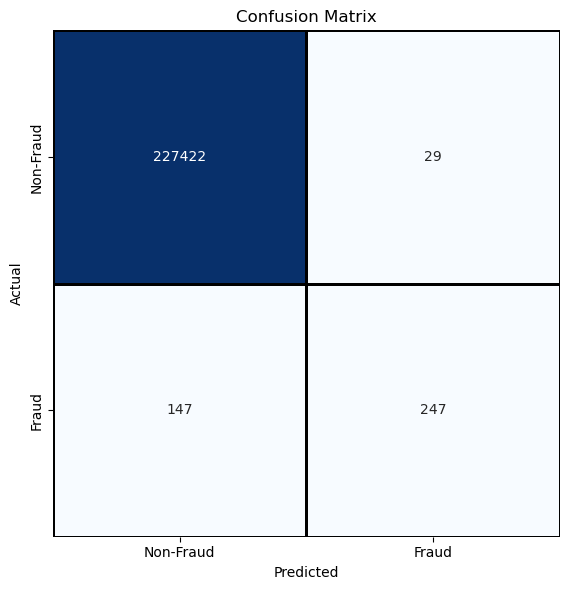

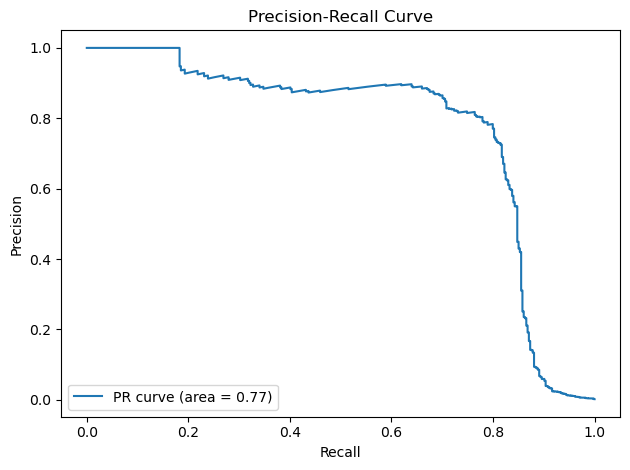

{'model': 'Logistic Regression - Train',
 'auprc_score': 0.7697135586346637,
 'accuracy': 0.9992275450415853,
 'precision': 0.894927536231884,
 'recall': 0.6269035532994924,
 'f1_score': 0.7373134328358208}

In [152]:
# Evaluate in the Training Data
res = [evaluate_model('Logistic Regression - Train', pipe, X_train, y_train)]
res[-1]

Since this is going to be an imbalanced classification model, the most important metrics is the `auprc_score`, visualized further by the Precision-Recall Curve. From the train data performance, it is actually already acceptable, but it still has an area of improvement.

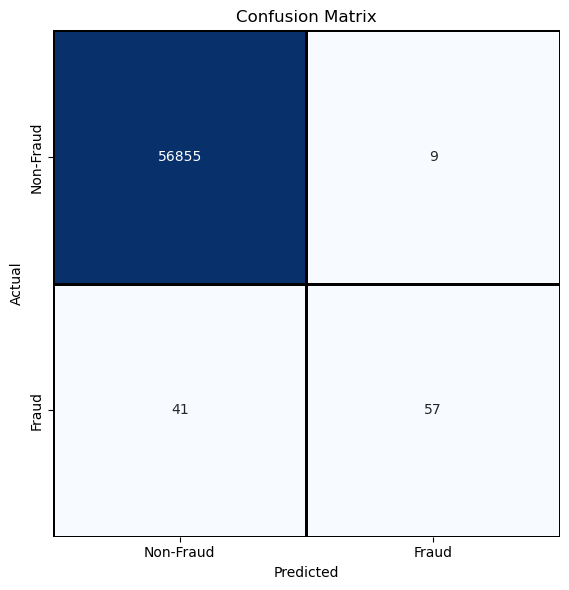

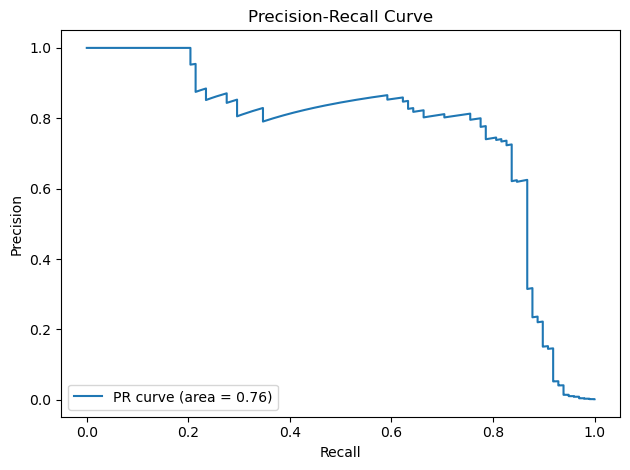

{'model': 'Logistic Regression - Test',
 'auprc_score': 0.7575310033673348,
 'accuracy': 0.9991222218320986,
 'precision': 0.8636363636363636,
 'recall': 0.5816326530612245,
 'f1_score': 0.6951219512195121}

In [153]:
# Evaluate in the Test Data
res.append(evaluate_model('Logistic Regression - Test', pipe, X_test, y_test))
res[-1]

The performance on the test results is similar to its performance on the train data

### Feature Selection

Even though most of the variables were a PCA extracted features, maybe a feature selection method will help given that in the correlation analysis there were some features that little to no correlation to the target variable.

In [154]:
# Adding a feature selection method in the pipeline
pipe = Pipeline(
    steps = [
        ('preproc', preproc),
        ('feature_selection', SelectKBest(f_classif, k=24)),
        ('model', LogisticRegression(solver='liblinear'))
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('feature_selection', SelectKBest(k=24)),
                ('model', LogisticRegression(solver='liblinear'))])

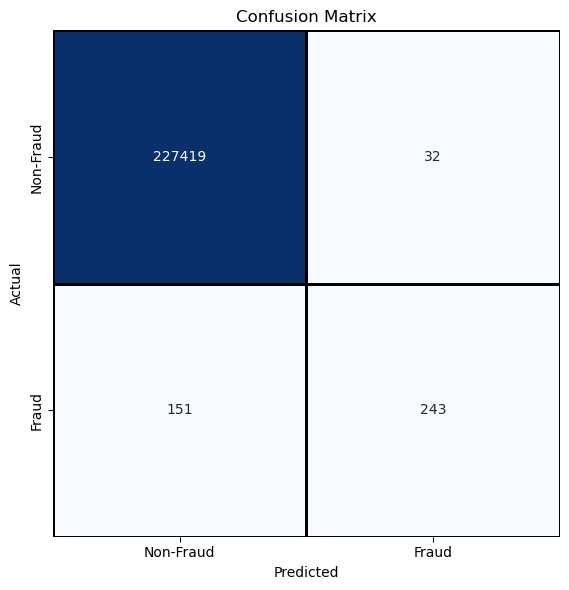

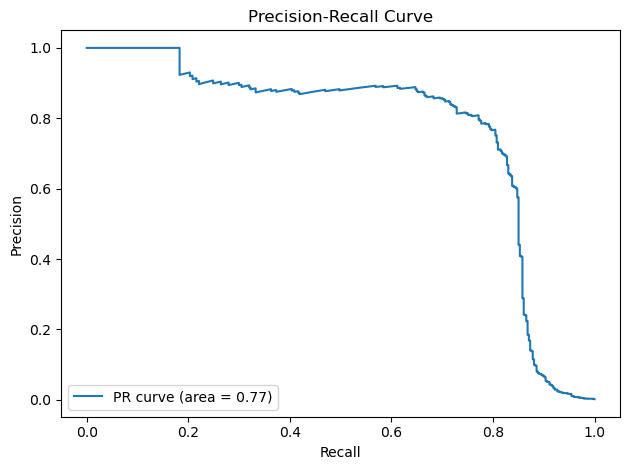

{'model': 'Logistic Regression (w/ Feature Selection) - Train',
 'auprc_score': 0.767500234808179,
 'accuracy': 0.9991968224011938,
 'precision': 0.8836363636363637,
 'recall': 0.616751269035533,
 'f1_score': 0.7264573991031391}

In [155]:
# Evaluate in the Train Data
res.append(evaluate_model('Logistic Regression (w/ Feature Selection) - Train', pipe, X_train, y_train))
res[-1]

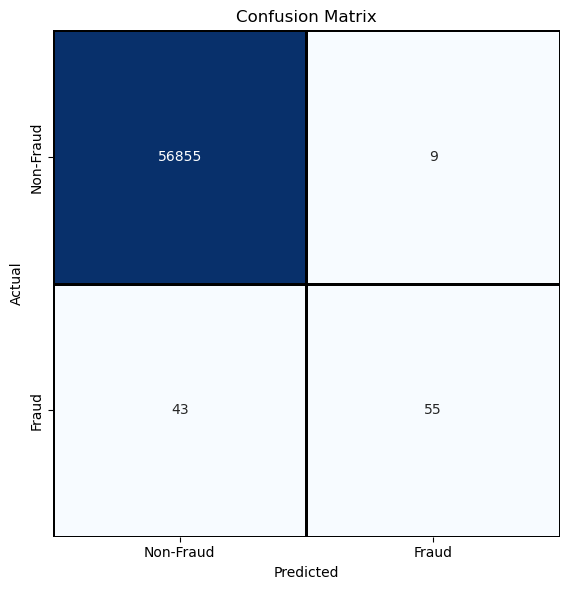

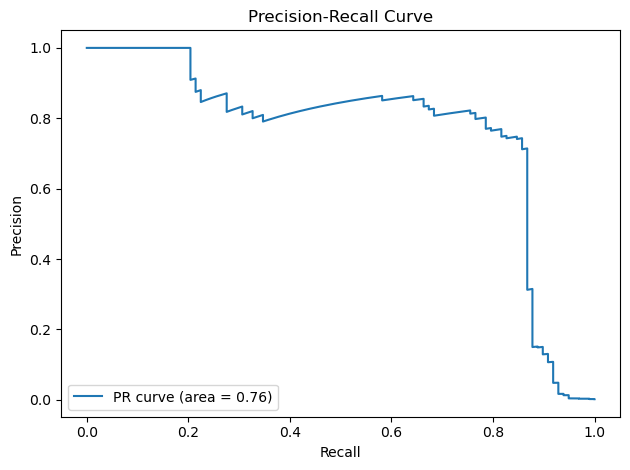

{'model': 'Logistic Regression (w/ Feature Selection) - Train',
 'auprc_score': 0.7604080743405223,
 'accuracy': 0.9990871107053826,
 'precision': 0.859375,
 'recall': 0.5612244897959183,
 'f1_score': 0.6790123456790124}

In [156]:
# Evaluate in the Test Data
res.append(evaluate_model('Logistic Regression (w/ Feature Selection) - Train', pipe, X_test, y_test))
res[-1]

Train and test performance in this case is similar to the results of regular training, hence feature selection in this use case will not help

### Undersampling

One way to address imbalance in the data is undersampling. For this case, we'll be using the inherent sample method of pandas.DataFrame

In [157]:
# Separate normal and fraud transactions
normal = X_train[y_train == 0]
fraud = X_train[y_train == 1]

# Print shape for reference
print(f"Normal transactions shape: {normal.shape}")
print(f"Fraud transactions shape: {fraud.shape}")

Normal transactions shape: (227451, 30)
Fraud transactions shape: (394, 30)


In [158]:
# Undersample normal transactions
normal_sample = normal.sample(n=fraud.shape[0])
print(f"New normal transactions shape: {normal_sample.shape}")

New normal transactions shape: (394, 30)


In [159]:
# Update the training data to the undersampled version
X_train_under = pd.concat([normal_sample, fraud])
y_train_under = y_train[X_train_under.index]
X_train_under.shape, y_train_under.shape

((788, 30), (788,))

In [160]:
# Using similar model, but trained with undersampled data
pipe = Pipeline(
    steps = [
        ('preproc', preproc),
        ('model', LogisticRegression(solver='liblinear'))
    ]
)

pipe.fit(X_train_under, y_train_under)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', LogisticRegression(solver='liblinear'))])

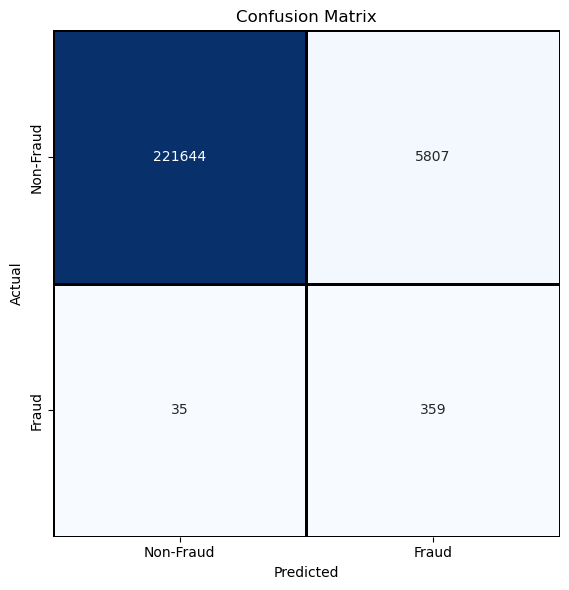

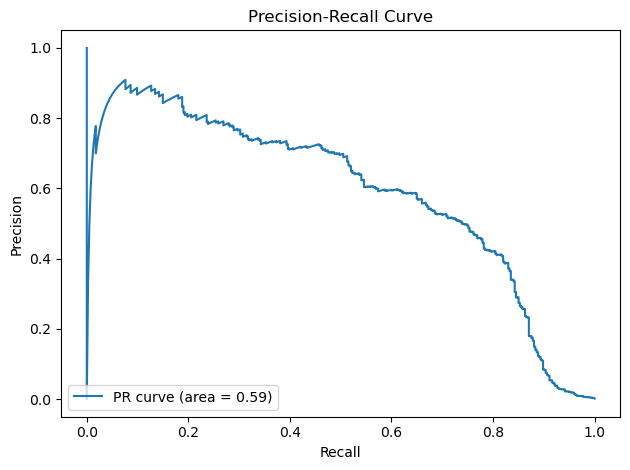

{'model': 'Logistic Regression (Undersampled) - Train',
 'auprc_score': 0.588684609665915,
 'accuracy': 0.9743597621189845,
 'precision': 0.058222510541680185,
 'recall': 0.9111675126903553,
 'f1_score': 0.10945121951219514}

In [161]:
# Train Results
res.append(evaluate_model('Logistic Regression (Undersampled) - Train', pipe, X_train, y_train))
res[-1]

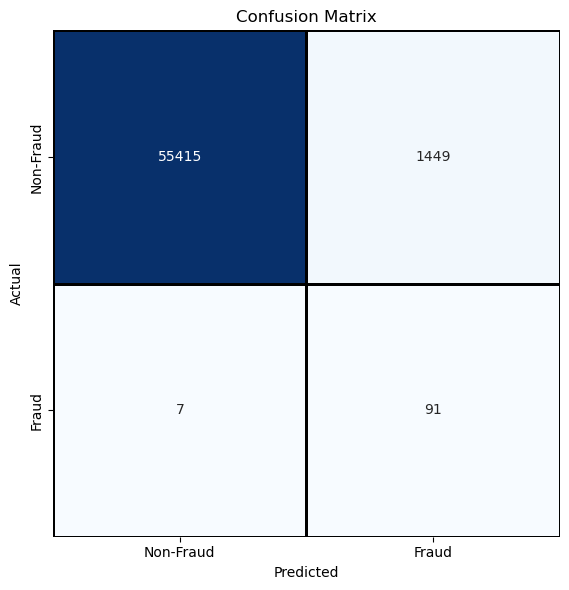

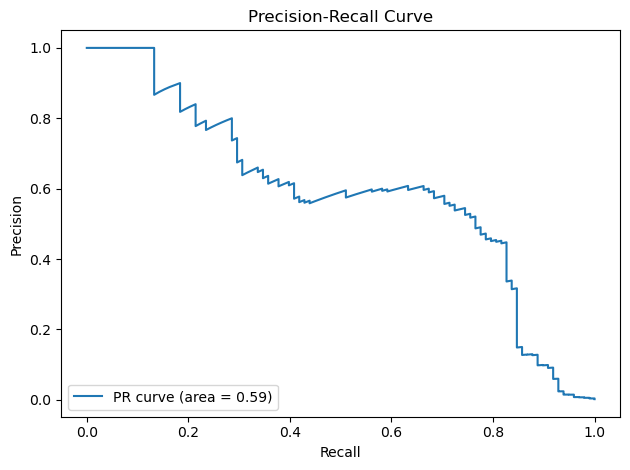

{'model': 'Logistic Regression (Undersampled) - Test',
 'auprc_score': 0.5893853717432226,
 'accuracy': 0.974439099750711,
 'precision': 0.05909090909090909,
 'recall': 0.9285714285714286,
 'f1_score': 0.1111111111111111}

In [162]:
# Test Results
res.append(evaluate_model('Logistic Regression (Undersampled) - Test', pipe, X_test, y_test))
res[-1]

### Oversampling

Another method to address class imbalance is through oversampling. In this case, we will be using the resample method in scikit-learn

In [163]:
# Split into majority and minority classes
X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

# Oversample the minority class
X_minority_oversampled, y_minority_oversampled = resample(X_minority, y_minority,
                                                          replace=True,  
                                                          n_samples=len(X_majority),  # Match majority class
                                                          random_state=42)  

# Combine oversampled minority class with original majority class
X_train_over = pd.DataFrame(np.vstack((X_majority, X_minority_oversampled)), columns=X_train.columns)
y_train_over = pd.Series(np.hstack((y_majority, y_minority_oversampled)), name='Class')

X_train_over.shape, y_train_over.shape


((454902, 30), (454902,))

In [164]:
# Using similar setup, but trained with oversampled data
pipe = Pipeline(
    steps = [
        ('preproc', preproc),
        ('model', LogisticRegression(solver='liblinear'))
    ]
)

pipe.fit(X_train_over, y_train_over)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', LogisticRegression(solver='liblinear'))])

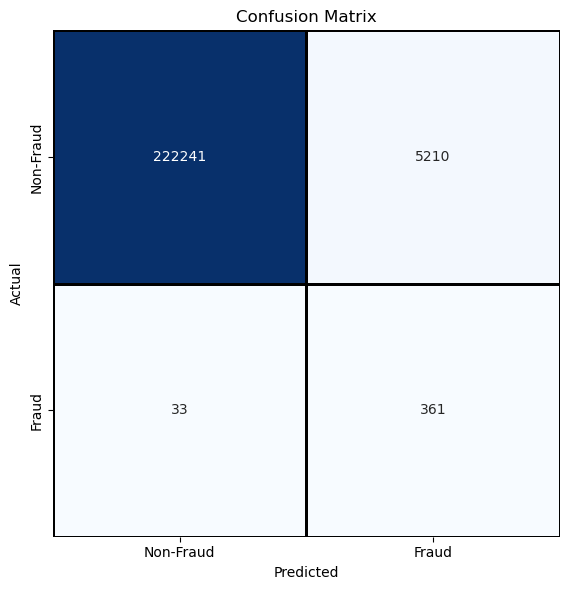

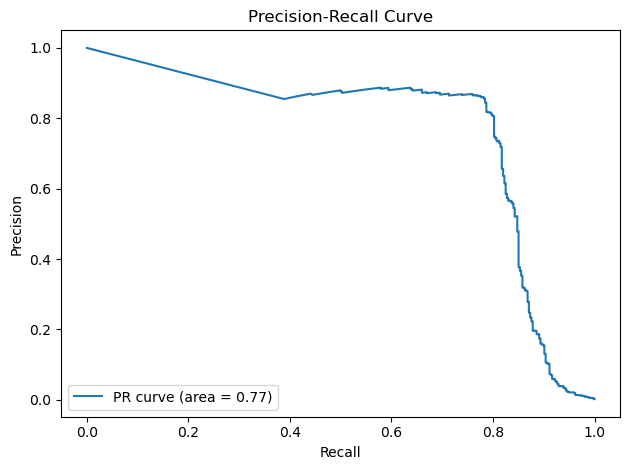

{'model': 'Logistic Regression (Oversampled) - Train',
 'auprc_score': 0.7664049103381361,
 'accuracy': 0.9769887423467708,
 'precision': 0.0647998563992102,
 'recall': 0.916243654822335,
 'f1_score': 0.12103939647946355}

In [165]:
# Train results
res.append(evaluate_model('Logistic Regression (Oversampled) - Train', pipe, X_train, y_train))
res[-1]

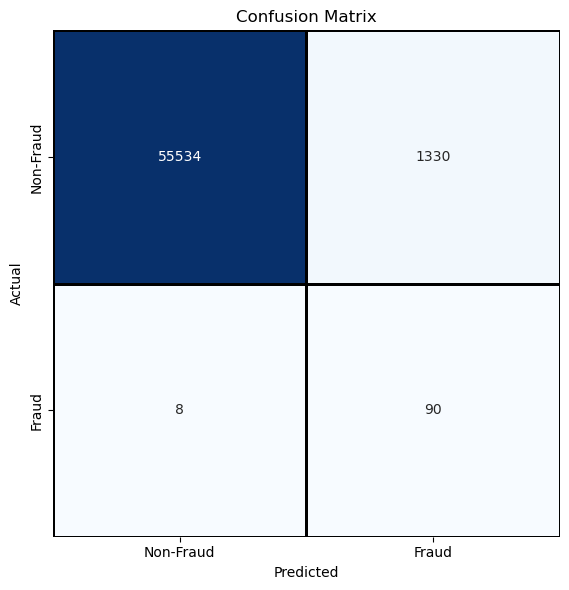

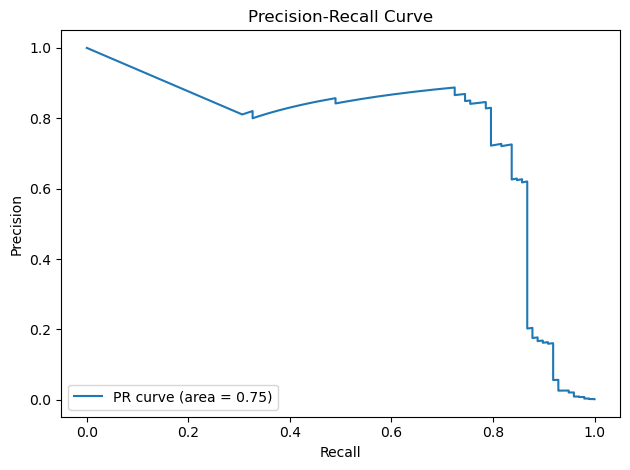

{'model': 'Logistic Regression (Oversampled) - Test',
 'auprc_score': 0.7529010990056852,
 'accuracy': 0.9765106562269583,
 'precision': 0.06338028169014084,
 'recall': 0.9183673469387755,
 'f1_score': 0.11857707509881422}

In [166]:
# Test results
res.append(evaluate_model('Logistic Regression (Oversampled) - Test', pipe, X_test, y_test))
res[-1]

## Decision Tree

### Regular Training

In [167]:
# Basic setup of a Decision Tree Classifier
pipe = Pipeline(
    steps = [
        ('preproc', preproc),
        ('model', DecisionTreeClassifier(max_depth=10))
    ]
)

# Fitting with the train data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', DecisionTreeClassifier(max_depth=10))])

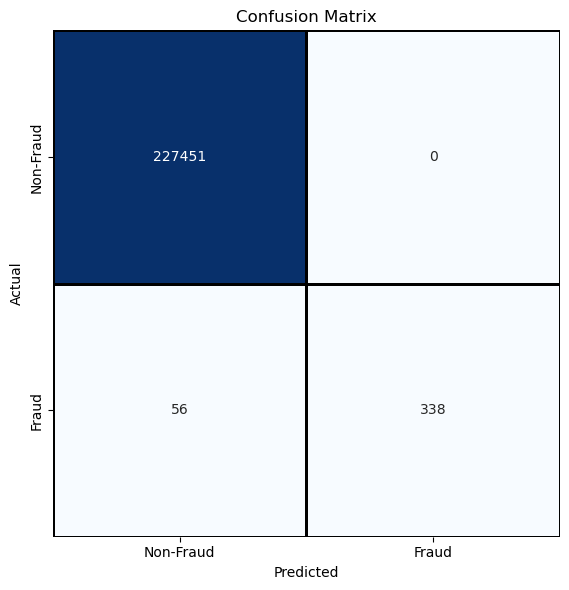

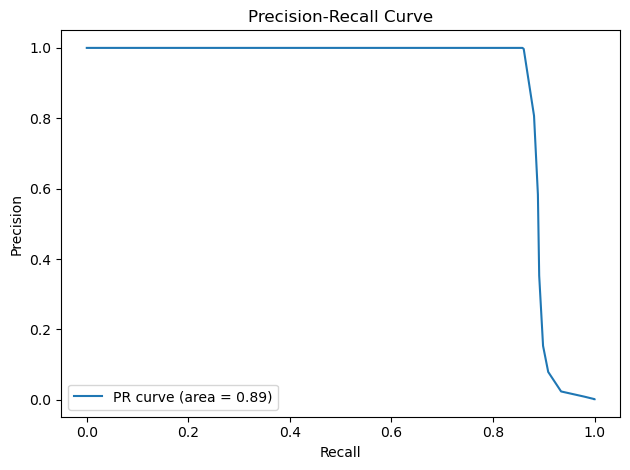

{'model': 'Decision Tree - Train',
 'auprc_score': 0.8904596033396629,
 'accuracy': 0.999754218876868,
 'precision': 1.0,
 'recall': 0.8578680203045685,
 'f1_score': 0.9234972677595629}

In [168]:
# Train results
res.append(evaluate_model('Decision Tree - Train', pipe, X_train, y_train))
res[-1]

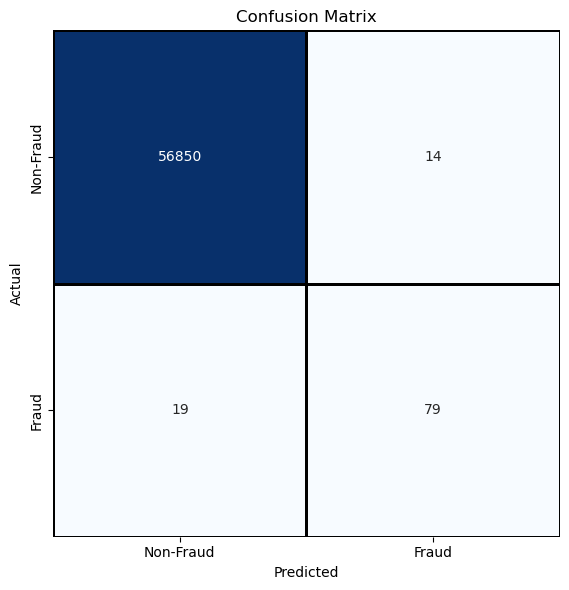

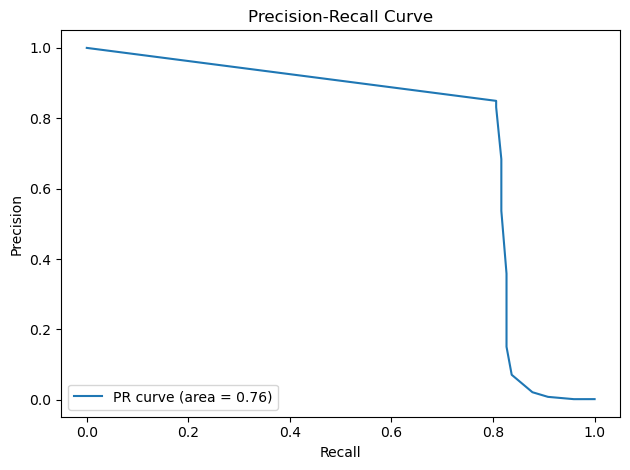

{'model': 'Decision Tree - Test',
 'auprc_score': 0.7615313748925756,
 'accuracy': 0.999420666409185,
 'precision': 0.8494623655913979,
 'recall': 0.8061224489795918,
 'f1_score': 0.8272251308900525}

In [169]:
# Test results
res.append(evaluate_model('Decision Tree - Test', pipe, X_test, y_test))
res[-1]

### Undersampling

In [170]:
# Using the same setup above, fit with undersampled train data
pipe.fit(X_train_under, y_train_under)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', DecisionTreeClassifier(max_depth=10))])

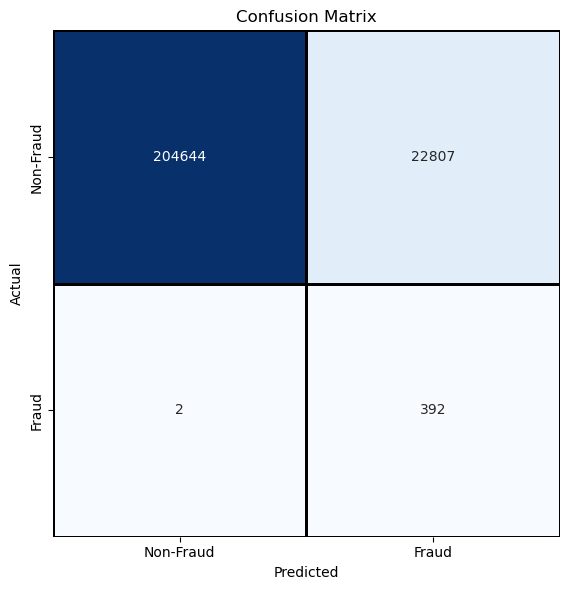

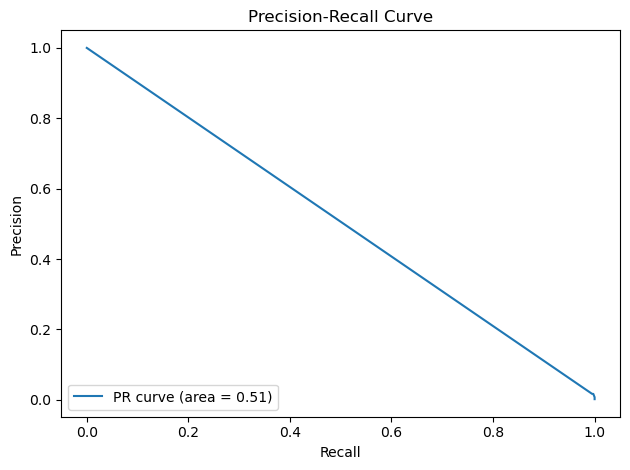

{'model': 'Decision Tree (Undersampled) - Train',
 'auprc_score': 0.5059404497623781,
 'accuracy': 0.8998924707586298,
 'precision': 0.016897280055174792,
 'recall': 0.9949238578680203,
 'f1_score': 0.03323019539693976}

In [171]:
# Train results
res.append(evaluate_model('Decision Tree (Undersampled) - Train', pipe, X_train, y_train))
res[-1]

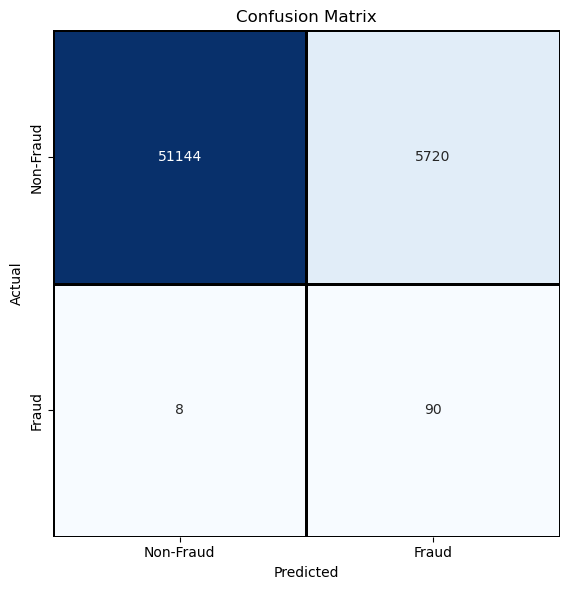

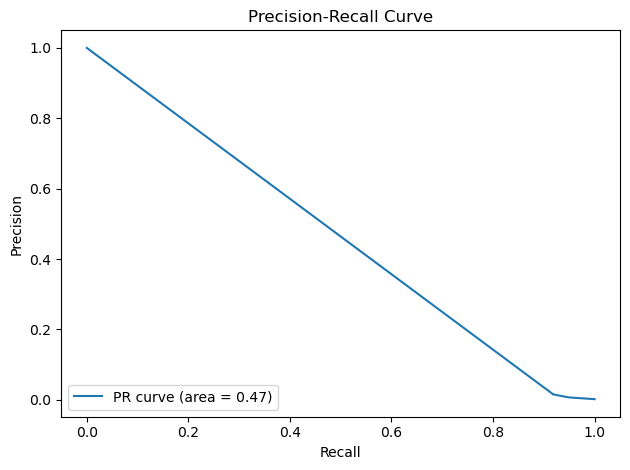

{'model': 'Decision Tree (Undersampled) - Test',
 'auprc_score': 0.4668499243864701,
 'accuracy': 0.8994417330852147,
 'precision': 0.01549053356282272,
 'recall': 0.9183673469387755,
 'f1_score': 0.03046716316858497}

In [172]:
# Test results
res.append(evaluate_model('Decision Tree (Undersampled) - Test', pipe, X_test, y_test))
res[-1]

### Oversampling

In [173]:
# Using the same setup, fit with the oversampled train data
pipe.fit(X_train_over, y_train_over)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', DecisionTreeClassifier(max_depth=10))])

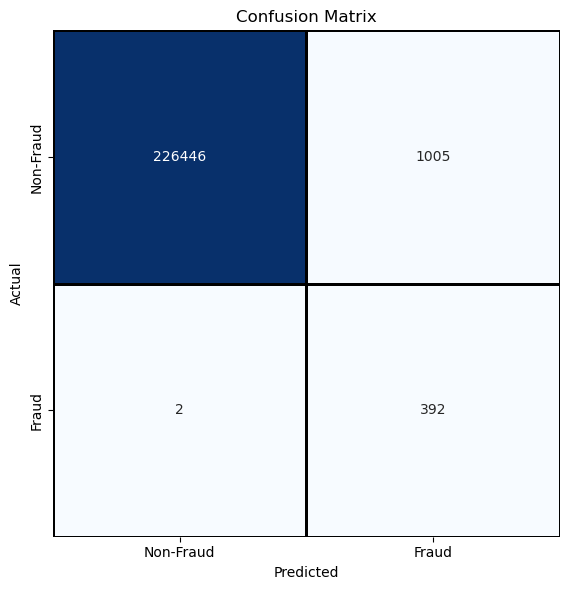

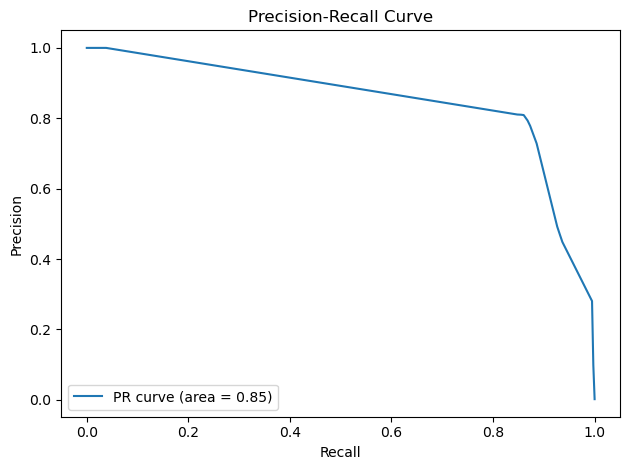

{'model': 'Decision Tree (Oversampled) - Train',
 'auprc_score': 0.8524466882367234,
 'accuracy': 0.9955803287322522,
 'precision': 0.28060128847530424,
 'recall': 0.9949238578680203,
 'f1_score': 0.43774427694025686}

In [174]:
# Train data
res.append(evaluate_model('Decision Tree (Oversampled) - Train', pipe, X_train, y_train))
res[-1]

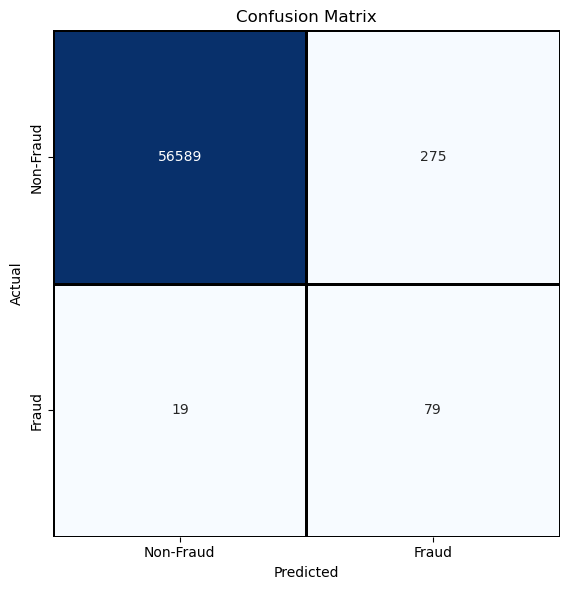

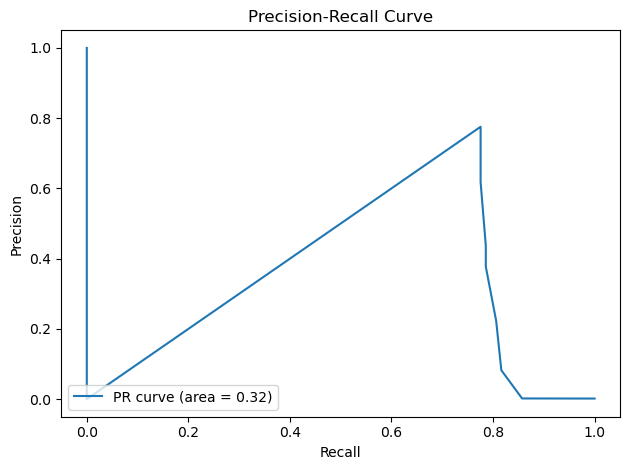

{'model': 'Decision Tree (Oversampled) - Test',
 'auprc_score': 0.3157681010408558,
 'accuracy': 0.9948386643727397,
 'precision': 0.2231638418079096,
 'recall': 0.8061224489795918,
 'f1_score': 0.3495575221238938}

In [175]:
# Test data
res.append(evaluate_model('Decision Tree (Oversampled) - Test', pipe, X_test, y_test))
res[-1]

## Random Forest

### Regular Training

In [176]:
# Basic setup of RF Classifier
pipe = Pipeline(
    steps = [
        ('preproc', preproc),
        ('model', RandomForestClassifier(max_depth=10))
    ]
)

# Fit with the train data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', RandomForestClassifier(max_depth=10))])

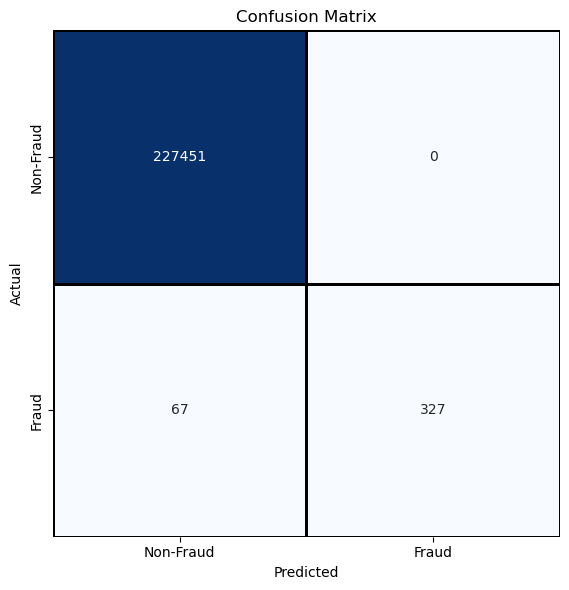

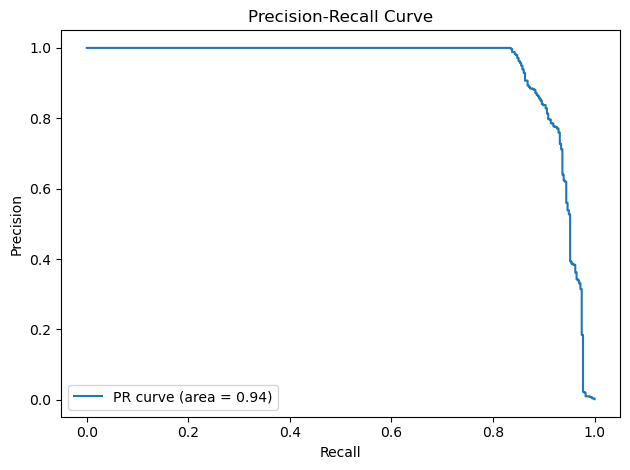

{'model': 'Random Forest - Train',
 'auprc_score': 0.940921236864314,
 'accuracy': 0.9997059404419671,
 'precision': 1.0,
 'recall': 0.8299492385786802,
 'f1_score': 0.9070735090152566}

In [177]:
# Train results
res.append(evaluate_model('Random Forest - Train', pipe, X_train, y_train))
res[-1]

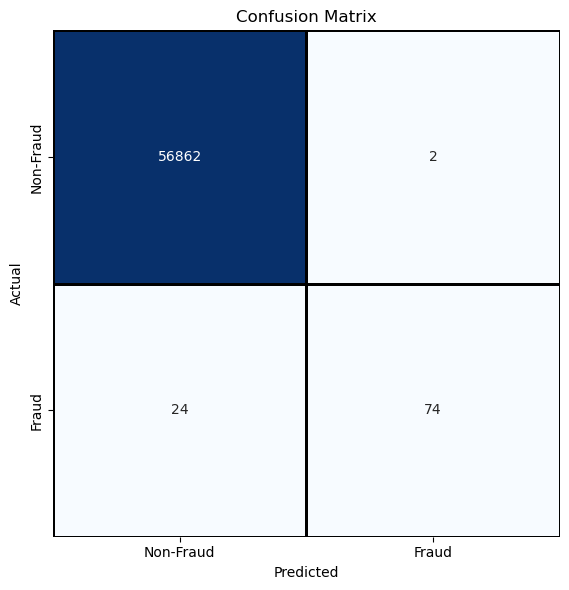

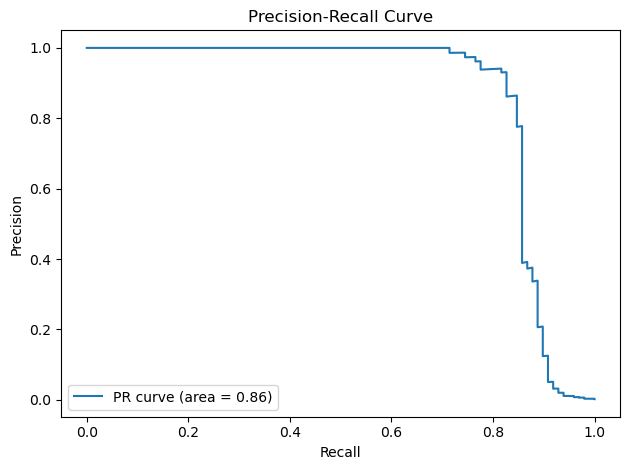

{'model': 'Random Forest - Test',
 'auprc_score': 0.86364490263602,
 'accuracy': 0.9995435553526912,
 'precision': 0.9736842105263158,
 'recall': 0.7551020408163265,
 'f1_score': 0.8505747126436782}

In [178]:
# Test results
res.append(evaluate_model('Random Forest - Test', pipe, X_test, y_test))
res[-1]

### Undersampling

In [179]:
# Using the same setup above, train with the undersampled data
pipe.fit(X_train_under, y_train_under)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', RandomForestClassifier(max_depth=10))])

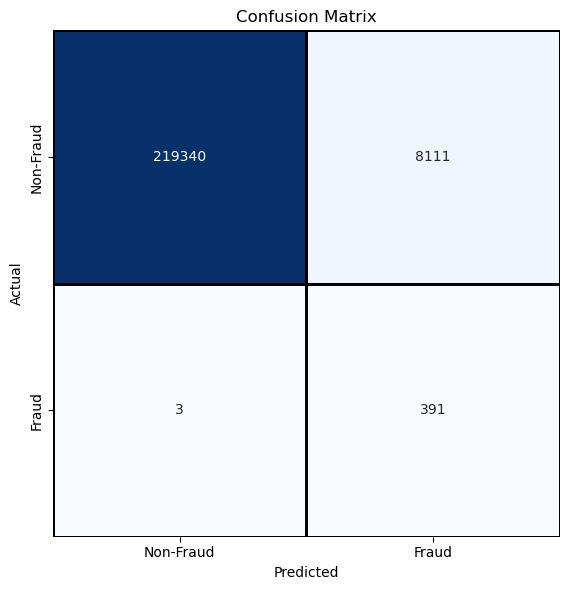

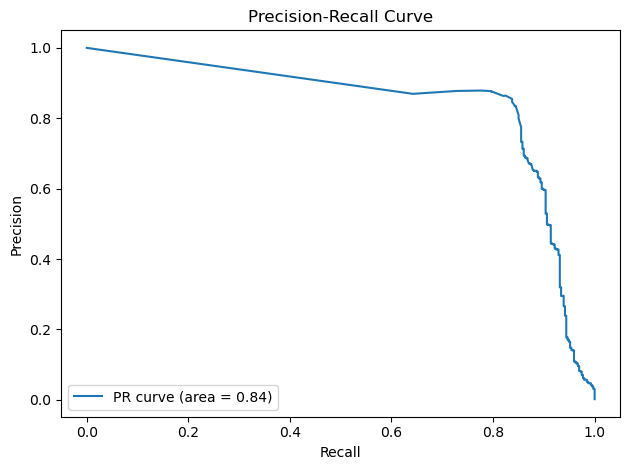

{'model': 'Random Forest (Undersampled) - Train',
 'auprc_score': 0.8386507989478098,
 'accuracy': 0.9643880708376309,
 'precision': 0.04598917901670195,
 'recall': 0.9923857868020305,
 'f1_score': 0.0879046762589928}

In [180]:
# Train results
res.append(evaluate_model('Random Forest (Undersampled) - Train', pipe, X_train, y_train))
res[-1]

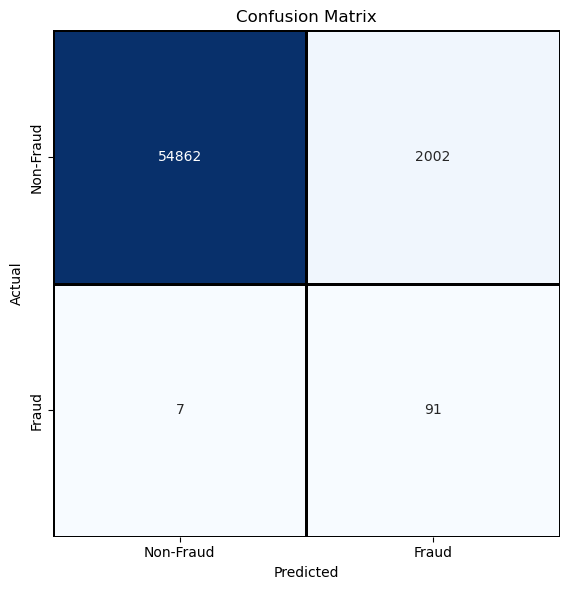

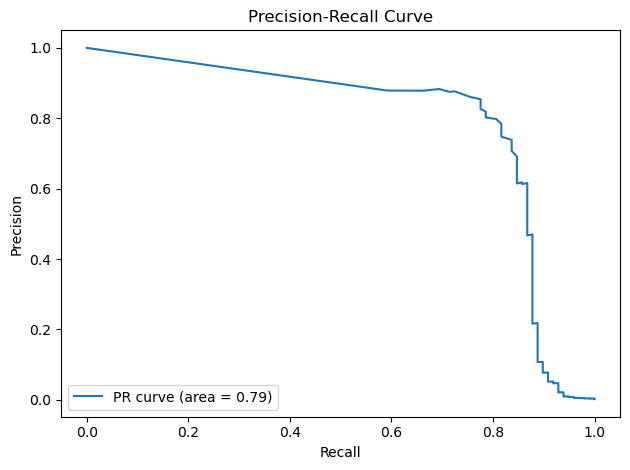

{'model': 'Random Forest (Undersampled) - Test',
 'auprc_score': 0.794750098778331,
 'accuracy': 0.9647308732137214,
 'precision': 0.043478260869565216,
 'recall': 0.9285714285714286,
 'f1_score': 0.08306709265175719}

In [181]:
#Test results
res.append(evaluate_model('Random Forest (Undersampled) - Test', pipe, X_test, y_test))
res[-1]

### Oversampling

In [182]:
# Using the same setup, train with the oversampled data
pipe.fit(X_train_over, y_train_over)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model', RandomForestClassifier(max_depth=10))])

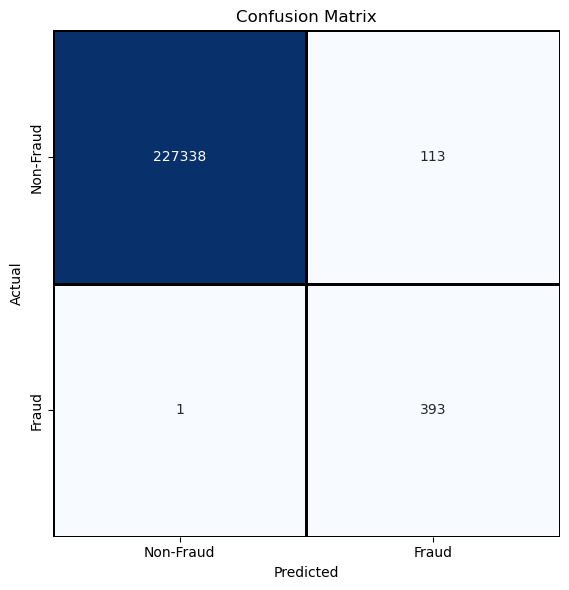

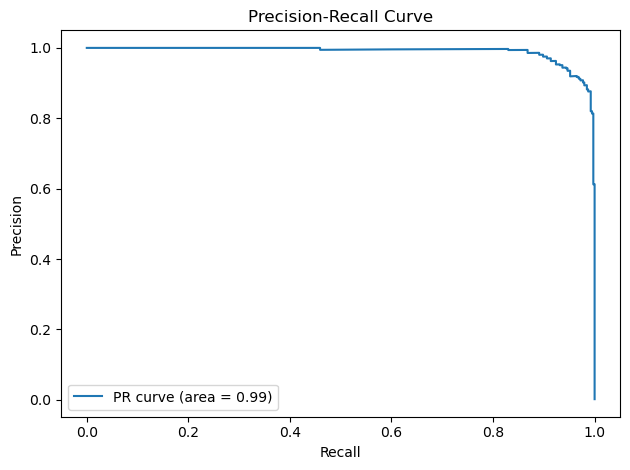

{'model': 'Random Forest (Oversampled) - Train',
 'auprc_score': 0.9897385627126016,
 'accuracy': 0.9994996598564814,
 'precision': 0.7766798418972332,
 'recall': 0.9974619289340102,
 'f1_score': 0.8733333333333333}

In [183]:
# Train results
res.append(evaluate_model('Random Forest (Oversampled) - Train', pipe, X_train, y_train))
res[-1]

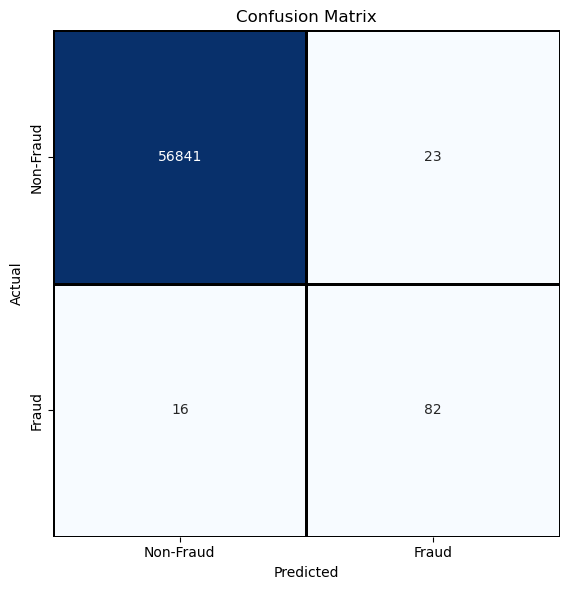

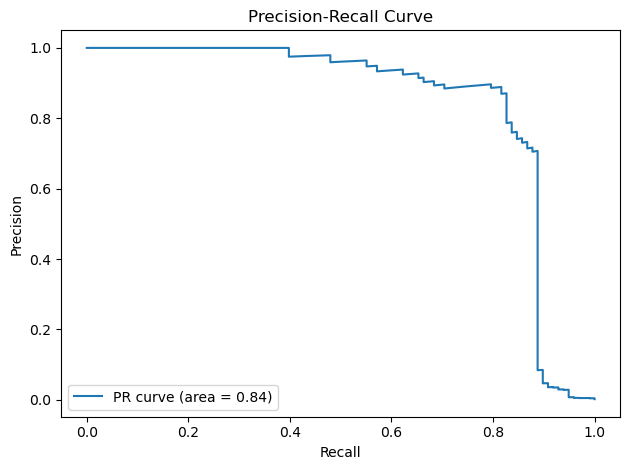

{'model': 'Random Forest (Oversampled) - Test',
 'auprc_score': 0.8449957233275255,
 'accuracy': 0.9993153330290369,
 'precision': 0.780952380952381,
 'recall': 0.8367346938775511,
 'f1_score': 0.8078817733990147}

In [184]:
# Test Results
res.append(evaluate_model('Random Forest (Oversampled) - Test', pipe, X_test, y_test))
res[-1]

## XGBoost

### Regular Training

In [185]:
# Basic setup of XGBoost Classifier
pipe = Pipeline(
    steps = [
        ('preproc', preproc),
        ('model', XGBClassifier())
    ]
)

# Train with the normal data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callb...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

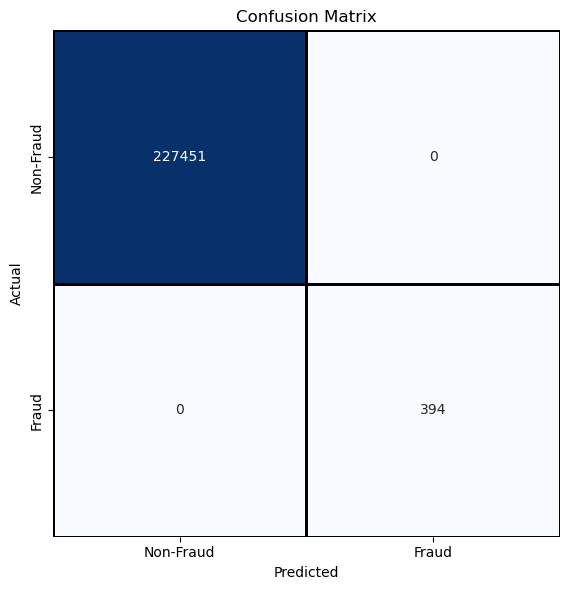

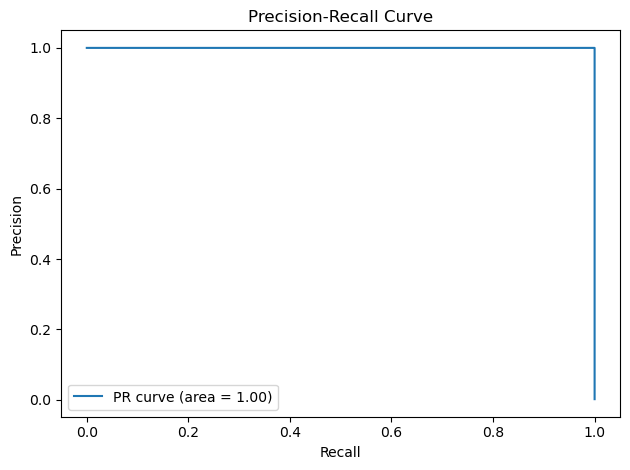

{'model': 'XGBoost - Train',
 'auprc_score': 1.0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0}

In [186]:
# Train results
res.append(evaluate_model('XGBoost - Train', pipe, X_train, y_train))
res[-1]

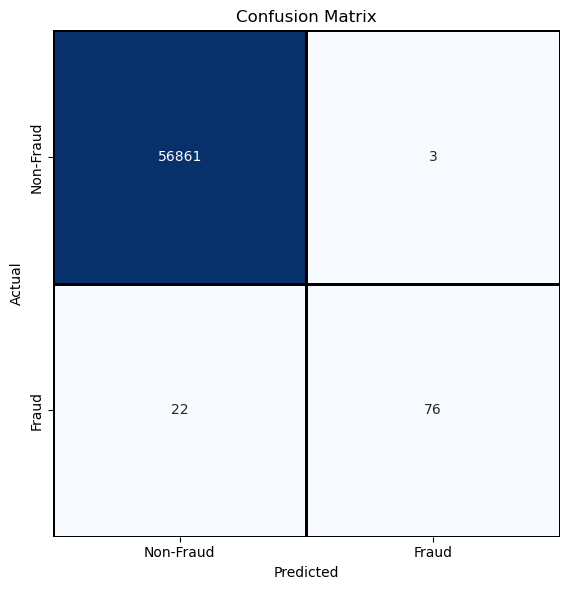

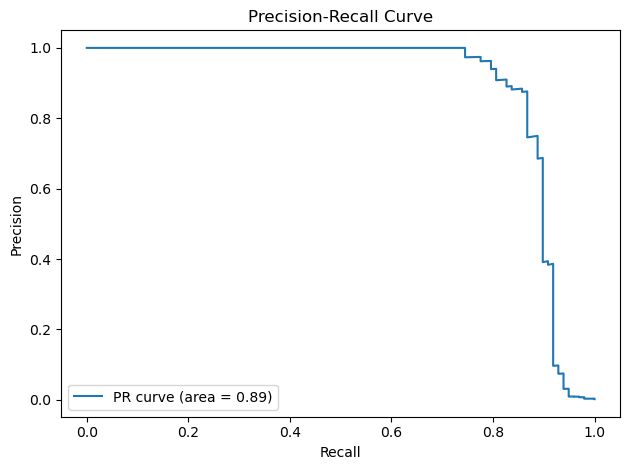

{'model': 'XGBoost - Test',
 'auprc_score': 0.8911248561648372,
 'accuracy': 0.9995611109160493,
 'precision': 0.9620253164556962,
 'recall': 0.7755102040816326,
 'f1_score': 0.8587570621468926}

In [187]:
# Test results
res.append(evaluate_model('XGBoost - Test', pipe, X_test, y_test))
res[-1]

### Undersampling

In [188]:
# Using the same setup above, train with the undersampled data
pipe.fit(X_train_under, y_train_under)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callb...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

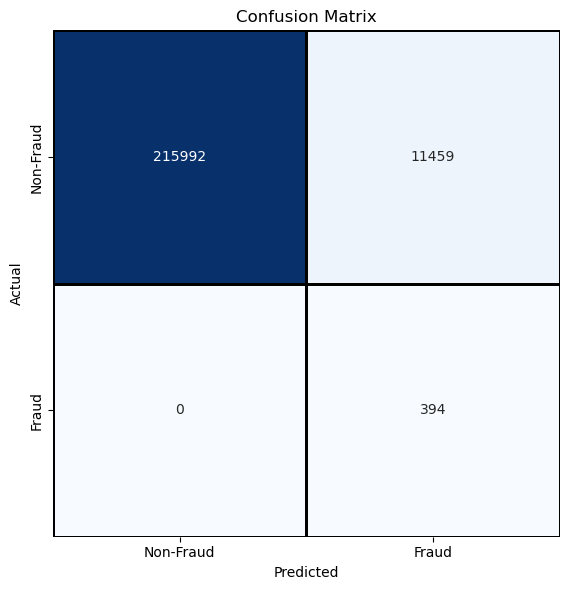

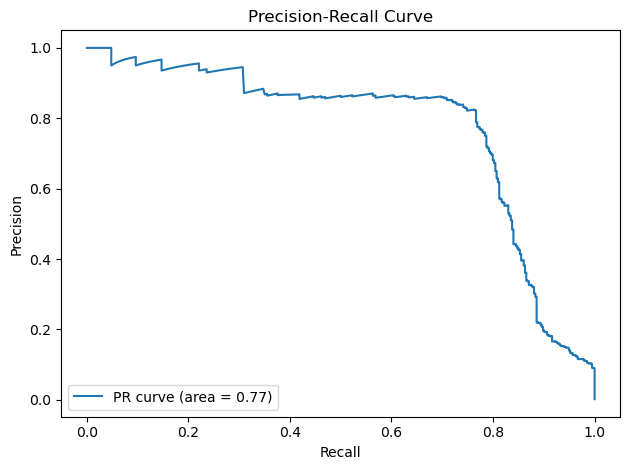

{'model': 'XGBoost (Undersampled) - Train',
 'auprc_score': 0.7715534837356699,
 'accuracy': 0.949707037679124,
 'precision': 0.03324052982367333,
 'recall': 1.0,
 'f1_score': 0.06434228790724258}

In [189]:
# Train results
res.append(evaluate_model('XGBoost (Undersampled) - Train', pipe, X_train, y_train))
res[-1]

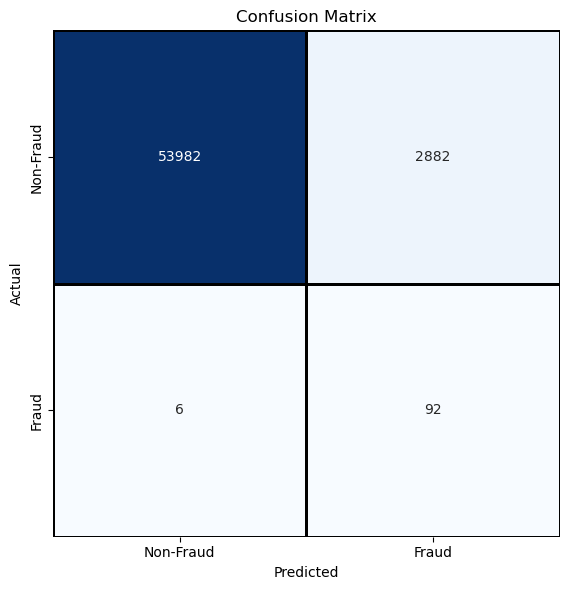

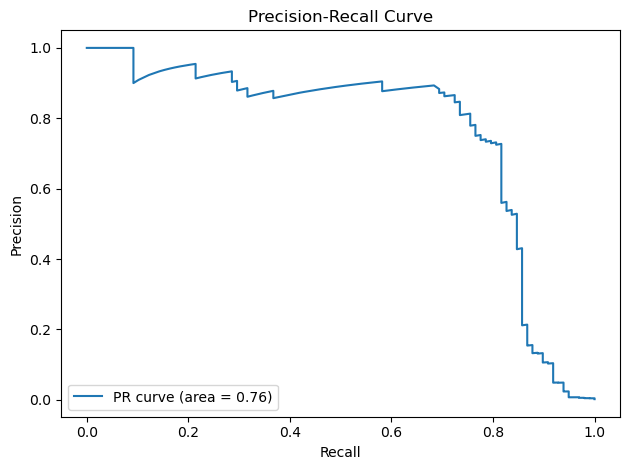

{'model': 'XGBoost (Undersampled) - Test',
 'auprc_score': 0.7610562405906994,
 'accuracy': 0.9492995330220146,
 'precision': 0.03093476798924008,
 'recall': 0.9387755102040817,
 'f1_score': 0.05989583333333333}

In [190]:
# Test results
res.append(evaluate_model('XGBoost (Undersampled) - Test', pipe, X_test, y_test))
res[-1]

### Oversampling

In [191]:
# Using the same setup, train with the oversampled data
pipe.fit(X_train_over, y_train_over)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['V9', 'V10', 'V2', 'V13',
                                                   'V27', 'Amount', 'Time',
                                                   'V1', 'V6', 'V14', 'V20',
                                                   'V16', 'V24', 'V18', 'V21',
                                                   'V19', 'V15', 'V28', 'V7',
                                                   'V26', 'V4', 'V22', 'V3',
                                                   'V5', 'V12', 'V25', 'V23',
                                                   'V11', 'V8', 'V17'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callb...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

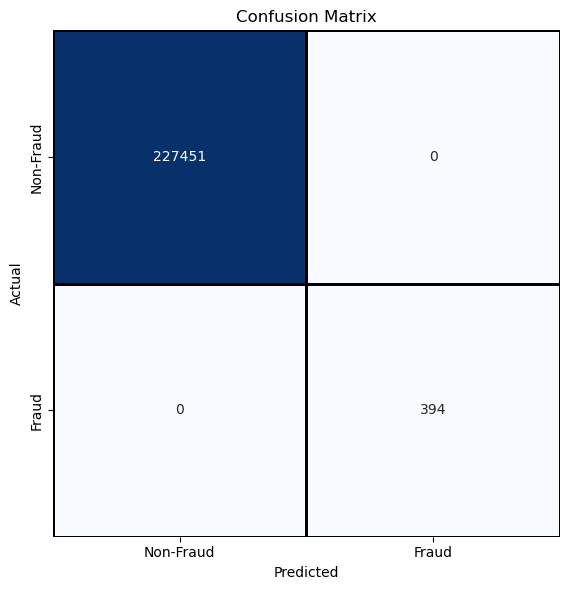

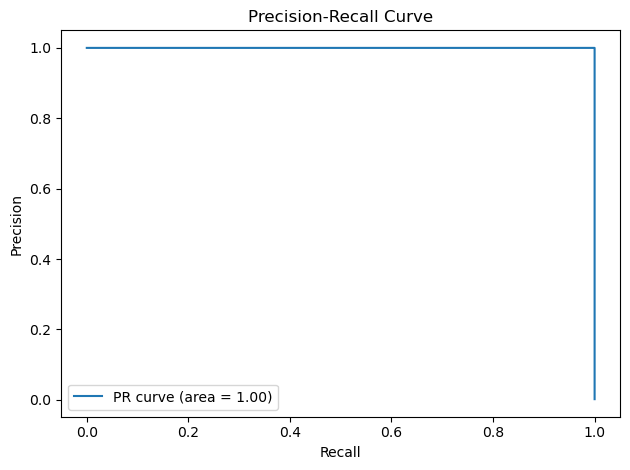

{'model': 'XGBoost (Oversampled) - Train',
 'auprc_score': 1.0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0}

In [192]:
# Train results
res.append(evaluate_model('XGBoost (Oversampled) - Train', pipe, X_train, y_train))
res[-1]

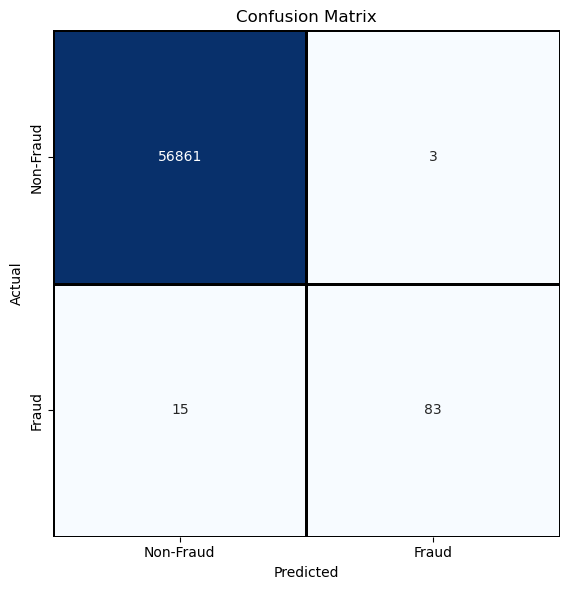

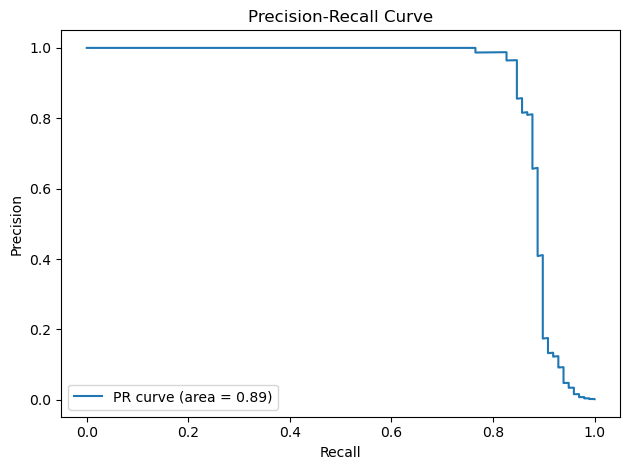

{'model': 'XGBoost (Oversampled) - Test',
 'auprc_score': 0.8881553660755934,
 'accuracy': 0.9996839998595555,
 'precision': 0.9651162790697675,
 'recall': 0.8469387755102041,
 'f1_score': 0.9021739130434784}

In [193]:
# Test results
res.append(evaluate_model('XGBoost (Oversampled) - Test', pipe, X_test, y_test))
res[-1]

# Results

Summary results of all setup on the test set

In [194]:
res_df = pd.DataFrame(res)
res_df

,model,auprc_score,accuracy,precision,recall,f1_score
0,Logistic Regression - Train,0.769714,0.999228,0.894928,0.626904,0.737313
1,Logistic Regression - Test,0.757531,0.999122,0.863636,0.581633,0.695122
2,Logistic Regression (w/ Feature Selection) - T...,0.767500,0.999197,0.883636,0.616751,0.726457
3,Logistic Regression (w/ Feature Selection) - T...,0.760408,0.999087,0.859375,0.561224,0.679012
4,Logistic Regression (Undersampled) - Train,0.588685,0.974360,0.058223,0.911168,0.109451
5,Logistic Regression (Undersampled) - Test,0.589385,0.974439,0.059091,0.928571,0.111111
6,Logistic Regression (Oversampled) - Train,0.766405,0.976989,0.064800,0.916244,0.121039
7,Logistic Regression (Oversampled) - Test,0.752901,0.976511,0.063380,0.918367,0.118577
8,Decision Tree - Train,0.890460,0.999754,1.000000,0.857868,0.923497
9,Decision Tree - Test,0.761531,0.999421,0.849462,0.806122,0.827225


In [195]:
regular_results = res_df[res_df.model.str.contains("Test")][~res_df.model.str.contains("Oversampled")][~res_df.model.str.contains("Undersampled")].sort_values(by = 'auprc_score', ascending = False)
regular_results

,model,auprc_score,accuracy,precision,recall,f1_score
21,XGBoost - Test,0.891125,0.999561,0.962025,0.775510,0.858757
15,Random Forest - Test,0.863645,0.999544,0.973684,0.755102,0.850575
9,Decision Tree - Test,0.761531,0.999421,0.849462,0.806122,0.827225
1,Logistic Regression - Test,0.757531,0.999122,0.863636,0.581633,0.695122


For regular models (w/o oversampling/undersampling method), XGBoost has the highest AUPRC score (0.891), indicating better performance in handling class imbalance. It also has the highest precision (0.962), though its recall (0.776) is slightly lower. Random Forest follows closely with high precision (0.973) but slightly lower recall (0.755). Decision Tree has a balanced recall and precision, while Logistic Regression shows the lowest scores, especially in recall (0.582), impacting its overall F1 score.

In [196]:
undersampled_results = res_df[res_df.model.str.contains("Test")][res_df.model.str.contains("Undersampled")].sort_values(by = 'auprc_score', ascending = False)
undersampled_results

,model,auprc_score,accuracy,precision,recall,f1_score
17,Random Forest (Undersampled) - Test,0.794750,0.964731,0.043478,0.928571,0.083067
23,XGBoost (Undersampled) - Test,0.761056,0.949300,0.030935,0.938776,0.059896
5,Logistic Regression (Undersampled) - Test,0.589385,0.974439,0.059091,0.928571,0.111111
11,Decision Tree (Undersampled) - Test,0.466850,0.899442,0.015491,0.918367,0.030467


For models trained with undersampled data, Random Forest performs best in terms of AUPRC (0.795) and F1 score (0.083), but has a very low precision (0.031), while maintaining high recall (0.949). XGBoost has lower AUPRC (0.761) and F1 score (0.06), but similar high recall (0.938). Logistic Regression and Decision Tree perform worse, with lower AUPRC scores (0.589 and 0.467 respectively) and very poor F1 scores, primarily due to extremely low precision across all undersampled models. 

These models are struggling to balance precision and recall, resulting in very poor overall performance when evaluated by F1 score. In terms of the most important metrics (AUPRC), undersampling method actually didn't improve the perfomance but rather worsen it.

In [197]:
oversampled_results = res_df[res_df.model.str.contains("Test")][res_df.model.str.contains("Oversampled")].sort_values(by = 'auprc_score', ascending = False)
oversampled_results

,model,auprc_score,accuracy,precision,recall,f1_score
25,XGBoost (Oversampled) - Test,0.888155,0.999684,0.965116,0.846939,0.902174
19,Random Forest (Oversampled) - Test,0.844996,0.999315,0.780952,0.836735,0.807882
7,Logistic Regression (Oversampled) - Test,0.752901,0.976511,0.063380,0.918367,0.118577
13,Decision Tree (Oversampled) - Test,0.315768,0.994839,0.223164,0.806122,0.349558


For models trained with oversampled data, XGBoost shows the best overall performance with an AUPRC of 0.888, high accuracy (0.999), and a strong balance between precision (0.965) and recall (0.847), leading to an F1 score of 0.902. Random Forest follows closely, with a slightly lower AUPRC (0.845) and precision (0.781), but a comparable recall (0.837), resulting in a good F1 score of 0.808. Logistic Regression performs poorly, with very low precision (0.063) despite high recall (0.918), reflected in a weak F1 score of 0.119. Decision Tree has the lowest AUPRC (0.316) and precision (0.223), with decent recall (0.806), but its F1 score of 0.350 indicates it struggles significantly.

However, when comparing to the performance of the model trained with regular data, it seems that oversampling doesn't really help much in this case.